### Bootstrapping the bounding boxes:
In this step we will use the finetuned model to generate new bounding boxes on the data that the model has not seen. The correctly predicted boxes will be used to further finetune the model and the incorrect boxes will be used to manually draw the bounding boxes in the images.

Steps:
1. Get the species and count from the preidcted bounding boxes (data in the folder - training_demo/Predictions/)
-- This is a TFRecord 

2. The LILA dataset does not have information on count and so I will use the concensus data for this information

In [1]:
#import pandas as pd
import csv, os, sys, io
import operator
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/')
from utils import dataset_util
#Added this to handle the truncation error while decoding the jpeg
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

pd.options.display.max_columns = 100

In [2]:
Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"

In [10]:
with open('../data/LILA/SnapshotSerengeti.json', 'r') as f:
    dict1 = json.load(f)

# read the bounding box annotations and the image information to dataframes
df_annotations = pd.DataFrame(dict1['annotations'])
# Removing the unknown category, humans and empty from the dataset
df_annotations = df_annotations.loc[~df_annotations['category_id'].isin([1000, 0, 1])]
print(df_annotations.shape)
df_images = pd.DataFrame(dict1['images'])
print(df_images.shape)
df_categories = pd.DataFrame(dict1['categories'])
print(df_categories.shape)

(864619, 3)
(3198737, 10)
(49, 2)


In [11]:
df_annotations.head()

,category_id,id,image_id
5,2,94cdea31-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0006
6,3,94cdea33-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0007
7,4,94cdea35-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0008
8,5,94cdea37-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0009
11,5,94cdea3d-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0012


In [12]:
df_images.head()

,datetime,file_name,frame_num,height,id,location,season,seq_id,seq_num_frames,width
0,2010-07-18 16:26:14,S1/B04/B04_R1/S1_B04_R1_PICT0001.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0001,B04,S1,ASG0002kjh,1,2048
1,2010-07-18 16:26:30,S1/B04/B04_R1/S1_B04_R1_PICT0002.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0002,B04,S1,ASG0002kji,1,2048
2,NaN,S1/B04/B04_R1/S1_B04_R1_PICT0003.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0003,B04,S1,ASG0002kjj,1,2048
3,NaN,S1/B04/B04_R1/S1_B04_R1_PICT0004.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0004,B04,S1,ASG0002kjk,1,2048
4,NaN,S1/B04/B04_R1/S1_B04_R1_PICT0005.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0005,B04,S1,ASG0002kjl,1,2048


In [13]:
df_categories.head()

,id,name
0,0,empty
1,1,human
2,2,gazelleGrants
3,3,reedbuck
4,4,dikDik


In [18]:
# 2.
# Join the tables df_annotations and df_images
df_bb_meta = pd.merge(left=df_annotations, 
                      right=df_images, 
                      how='left',
                      left_on=df_annotations['image_id'], 
                      right_on=df_images['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id_y'])

df_bb_meta = pd.merge(left=df_bb_meta, 
                      right=df_categories, 
                      how='left',
                      left_on=df_bb_meta['category_id'], 
                      right_on=df_categories['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id'])
print("Shape of data: ", df_bb_meta.shape)

Shape of data:  (864619, 13)


In [17]:
df_bb_meta.head(n = 2)

,category_id,id_x,image_id,datetime,file_name,frame_num,height,location,season,seq_id,seq_num_frames,width,name
0,2,94cdea31-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0006,2010-07-24 08:20:10,S1/B04/B04_R1/S1_B04_R1_PICT0006.JPG,0,1536,B04,S1,ASG0002kjm,1,2048,gazelleGrants
1,3,94cdea33-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0007,2010-07-24 10:14:32,S1/B04/B04_R1/S1_B04_R1_PICT0007.JPG,0,1536,B04,S1,ASG0002kjn,1,2048,reedbuck


Run through the TFRecord and check the count and list of animals. logic: <br>
1. Predictions Species, count per image
2. Ground truth Species, count per image from Concensus data or data prepped by marco

In [19]:
# Loading the json dump  
with open('../data/LILA/label_map.json', 'r') as f:
     label_map = json.load(f)

inv_label_map = {v: k for k, v in label_map.items()}
print(inv_label_map)

{1: 'human', 2: 'gazelleGrants', 3: 'reedbuck', 4: 'dikDik', 5: 'zebra', 6: 'porcupine', 7: 'gazelleThomsons', 8: 'hyenaSpotted', 9: 'warthog', 10: 'impala', 11: 'elephant', 12: 'giraffe', 13: 'mongoose', 14: 'buffalo', 15: 'hartebeest', 16: 'guineaFowl', 17: 'wildebeest', 18: 'leopard', 19: 'ostrich', 20: 'lionFemale', 21: 'koriBustard', 22: 'otherBird', 23: 'batEaredFox', 24: 'bushbuck', 25: 'jackal', 26: 'cheetah', 27: 'eland', 28: 'aardwolf', 29: 'hippopotamus', 30: 'hyenaStriped', 31: 'aardvark', 32: 'hare', 33: 'baboon', 34: 'vervetMonkey', 35: 'waterbuck', 36: 'secretaryBird', 37: 'serval', 38: 'lionMale', 39: 'topi', 40: 'honeyBadger', 41: 'rodents', 42: 'wildcat', 43: 'civet', 44: 'genet', 45: 'caracal', 46: 'rhinoceros', 47: 'reptiles', 48: 'zorilla'}


**Information about species and count in groundtruth/classification data (marco's data on msi)**

In [21]:
# Loaing the classification data created by Marco
df = pd.read_csv('../data/LILA/db_export_season_all_cleaned.csv')

# data preprocessing 
df_image1 = df[['species', 'count', 'image1']]
df_image1 = df_image1.rename(columns = {'image1':'filename'}, index=str)
print(df_image1.shape)

df_image2 = df[['species', 'count', 'image2']]
df_image2 = df_image2.rename(columns = {'image2':'filename'}, index=str)
print(df_image2.shape)

df_image3 = df[['species', 'count', 'image3']]
df_image3 = df_image1.rename(columns = {'image3':'filename'}, index=str)
print(df_image3.shape)

df_image1 = df_image1.append(df_image2)
df_image1 = df_image1.append(df_image3)

# The groundtruth/classification data has a lot empty images. removing the empty images
df_image1 = df_image1[df_image1['species']!= 'empty']
print(df_image1.shape)

df_image1.head()

(1896164, 3)
(1896164, 3)
(1896164, 3)
(1455270, 3)


,species,count,filename
0,human,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0001.JPG
1,human,2,SER/S1/B04/B04_R1/S1_B04_R1_PICT0002.JPG
5,gazellegrants,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0006.JPG
6,reedbuck,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0007.JPG
7,dikdik,1,SER/S1/B04/B04_R1/S1_B04_R1_PICT0008.JPG


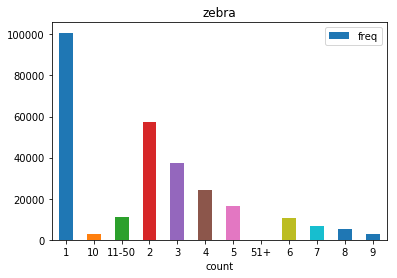

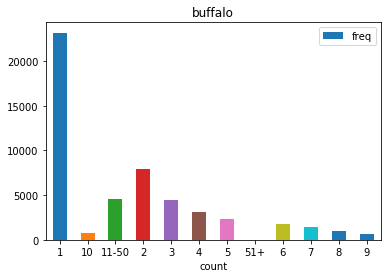

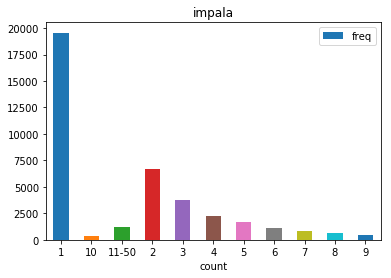

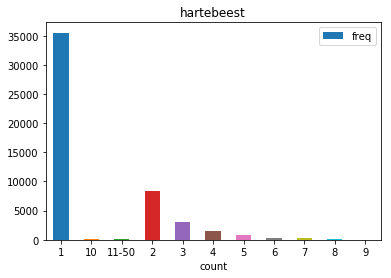

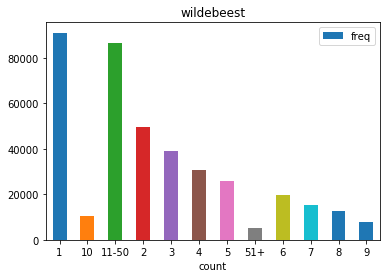

In [59]:
df_image2 = df_image1.groupby(by=['species', 'count'], as_index=False).count()
df_image3 = df_image2.sort_values(by=['species', 'count'])\
                            .rename(index=str, columns={'filename':'freq'})
#df_image1[df_image1['count']=='51+'] #.drop_duplicates(['filename'])#[['count', 'filename']]
df_image3

for species in ['zebra', 'buffalo', 'impala', 'hartebeest', 'wildebeest']:
    df_inter = df_image3[df_image3['species']==species][['count', 'freq']]
    ax = df_inter.plot.bar(x='count', y='freq', rot=0, title=species)

In [243]:
print(len(set(df_image1['filename'])))
print((df_image1[df_image1['count']=='51+'].drop_duplicates(['filename']).shape[0]+df_image1[df_image1['count']=='11-50'].drop_duplicates(['filename']).shape[0])/(len(set(df_image1['filename']))))

848131
0.09473064892098036


In [61]:
df_temp = df_image1.to_dict(orient='index')
db_dict = {}

for i, row in df_temp.items():
    filename = row['filename']
    if filename not in db_dict.keys():
        db_dict[filename] = {}
        db_dict[filename]['Species'] = []
        db_dict[filename]['CountMedian'] = []
    db_dict[filename]['Species'].append(row['species'])
    db_dict[filename]['CountMedian'].append(row['count'])

In [62]:
# checking the dictionary
db_dict['SER/S1/B05/B05_R1/S1_B05_R1_PICT0038.JPG']

{'CountMedian': ['2'], 'Species': ['zebra']}

In [64]:
def decode_record(serialized_example):
    context_features = {
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/detection/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/detection/label" : tf.VarLenFeature(tf.int64),
                        "image/detection/score" : tf.VarLenFeature(tf.float32)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

In [65]:
filename_list = ['/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.record']
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(filename_list)
dataset = tf.data.TFRecordDataset(dataset)
# dataset = dataset.shuffle(buffer_size=batch_size)
# dataset = dataset.repeat(1)
dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)

iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next()

# print(dataset.output_types)
# print(dataset.output_shapes) 

In [66]:
# batch_data = iterator.get_next()
with tf.Session() as sess:
    (context, sequence) = sess.run(batch_data)
    img = context['image/encoded']
    # Detection 
    filename = context['image/filename']
    xmin_d = (context['image/detection/bbox/xmin'])
    ymin_d = (context['image/detection/bbox/ymin'])
    xmax_d = (context['image/detection/bbox/xmax'])
    ymax_d = (context['image/detection/bbox/ymax'])
    label_d = (context['image/detection/label'])
    score = (context['image/detection/score'])
    
    score_threshold = 0.5
    no_groundtruth = [] # list of mages with no groundtruth
    correct_prediction = [] # Storing the image name of the correct predictions
    incorrect_prediction = [] # Storing the image name of the incorrect predictions
    
    for rec_i in range(len(img)):
        encoded_jpg_io = io.BytesIO(img[rec_i])
        image = Image.open(encoded_jpg_io)
        width, height = image.size
        
        xmins_d, ymins_d, xmaxs_d, ymaxs_d, labels_d, scores = [], [], [], [], [], []
        
        for j in range(rec_i*75, (rec_i+1)*75):
            if xmin_d[0][j][0] == rec_i and score[1][j]>=score_threshold:
                xmins_d.append(int(xmin_d[1][j]*width))
                ymins_d.append(int(ymin_d[1][j]*height))
                xmaxs_d.append(int(xmax_d[1][j]*width))
                ymaxs_d.append(int(ymax_d[1][j]*height))
                labels_d.append(inv_label_map[label_d[1][j]])
                scores.append(round(score[1][j]*100, 1))
        
        species_p, counts_p = np.unique(labels_d, return_counts=True)      
#         print(rec_i, filename[rec_i].decode('ascii')  + '.JPG', species_p, counts_p)
        
        # Matching the count and species in the Prediction and the groundtruth
        # Correct prediction will have matching species and count
#         if ground truth information is not present about the count and species then skip?
        if db_dict.get('SER/' + filename[rec_i].decode('ascii') + '.JPG'):
#             print(db_dict.get('SER/' + filename[rec_i].decode('ascii') + '.JPG'))
            gt_species, gt_count = db_dict['SER/' + filename[rec_i].decode('ascii') + '.JPG']['Species'], db_dict['SER/' + filename[rec_i].decode('ascii') + '.JPG']['CountMedian']
            print('groundtruth:', gt_species, gt_count, '\t \t' ,'predictions:', species_p, counts_p)  
        else:
            no_groundtruth.append(filename[rec_i].decode('ascii'))
            print('------------------------ NO GROUNDTRUTH FOUND ------------------------')   
            
        # Checking the groundtruth vs prediction

groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: ['zebra'] [1]
groundtruth: ['zebra'] ['1'] 	 	 predictions: [] []
groundtruth: ['gazellethomsons'] ['1'] 	 	 predictions: ['gazelleThomsons'] [1]
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['gazellethomsons'] ['1'] 	 	 predictions: ['gazelleThomsons'] [1]
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['gazellethomsons'] ['1'] 	 	 predictions: ['gazelleThomsons'] [1]
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['hyenaspotted'] ['1'] 	 	 predictions: [] []
------------------------ NO GROUNDTRUTH FOUND ------------------------
groundtruth: ['warthog'] ['1'] 	 	 predictions: ['warthog'] [1]
------------------------ NO GROUNDTRUTH FOUND ---------------

In [222]:
print('groundtruth available for: ', abs(len(no_groundtruth) - len(img)))

groundtruth available for:  11


In [223]:
file_p = [file.decode('ascii') for file in filename]
file = [f.split('/')[3] for f in list(db_dict.keys())]
# set(file) & set(file_p)
# file_p

In [48]:
import numpy as np
words = ['d', 'a', 'd']
values, counts = np.unique(words, return_counts=True)
print(values, counts)

['a' 'd'] [1 2]


In [28]:
words, count = ['d', 'a', 'z', 'y'], [2, 1, 5, 10]
m = sorted(range(len(words)), key=lambda k: words[k])
sorted(words), [count[i] for i in m] 
m

[1, 0, 3, 2]